# Full Analysis

In [1]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import classification_report, roc_curve, auc

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Data Loading
1. To optimize memory, learned from the algorithm's class, I optimized the data types while reading the data in.
2. Parsed `timestamp` as **datetime** object while reading in the data.

In [2]:
genome_scores = pd.read_csv(
    '../data/genome_scores.csv', 
    dtype={'movieId': 'int32', 'tagId': 'int32', 'relevance': 'float32'}
)
print(f"Genome Scores loaded: {genome_scores.shape}")

genome_tags = pd.read_csv('../data/genome_tags.csv')
print(f"Genome Tags loaded: {genome_tags.shape}")

link = pd.read_csv('../data/link.csv')
print(f"Links loaded: {link.shape}")

movie = pd.read_csv('../data/movie.csv')
print(f"Movie metadata loaded: {movie.shape}")

rating = pd.read_csv(
    '../data/rating.csv', 
    dtype={'movieId': 'int32', 'tagId': 'int32', 'relevance': 'float32'},
    parse_dates=['timestamp']
)
print(f"Ratings loaded: {rating.shape}")

tag = pd.read_csv('../data/tag.csv', parse_dates=['timestamp'])
print(f"User tags loaded: {tag.shape}")

print("All files done loading :)")

Genome Scores loaded: (11709768, 3)
Genome Tags loaded: (1128, 2)
Links loaded: (27278, 3)
Movie metadata loaded: (27278, 3)
Ratings loaded: (20000263, 4)
User tags loaded: (465564, 4)
All files done loading :)


# Data Preprocessing
1. Left-joined `rating` with `movie` on `movieId` to get the corresponding ratings for each movie. The `movie` dataset also included the movie `genres`, which is one of the key features I want to extract for predicting movie ratings.
2. Created a new column `target` for the response variable as 1 when rating >= 4 and 0 when rating < 4.
3. Check for class balance of the target classes -> turns out the data is very balanced
4. Expanded the `genres` column and created binary columns for each genre -> easier for the model to parse.

Performed some basic EDA by using the Data Explorer tab on Kaggle, and also `df.info()`.

In [3]:
df = rating.merge(movie, on='movieId', how='left')
df['target'] = (rating['rating'] >= 4).astype(int)

df.head()

,userId,movieId,rating,timestamp,title,genres,target
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy,0
1,1,29,3.5,2005-04-02 23:31:16,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,0
2,1,32,3.5,2005-04-02 23:33:39,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,0
3,1,47,3.5,2005-04-02 23:32:07,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,0
4,1,50,3.5,2005-04-02 23:29:40,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 7 columns):
 #   Column     Dtype         
---  ------     -----         
 0   userId     int64         
 1   movieId    int32         
 2   rating     float64       
 3   timestamp  datetime64[ns]
 4   title      object        
 5   genres     object        
 6   target     int64         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(2), object(2)
memory usage: 991.8+ MB


In [5]:
# See the count of the target classes
print("Class Balance:")
print(df['target'].value_counts(normalize=True))

Class Balance:
target
0    0.500236
1    0.499764
Name: proportion, dtype: float64


In [6]:
# Create the binary columns from the original 'genres' string
genre_dummies = df['genres'].str.get_dummies(sep='|')

# Attach them to the dataframe
df_processed = pd.concat([df, genre_dummies], axis=1)

# Get the list of these new column names for later
genre_feature_names = genre_dummies.columns.tolist()
print(f"Genre Features: {genre_feature_names}")

Genre Features: ['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [7]:
df_processed.head()

,userId,movieId,rating,timestamp,title,genres,target,(no genres listed),Action,Adventure,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,29,3.5,2005-04-02 23:31:16,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
2,1,32,3.5,2005-04-02 23:33:39,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
3,1,47,3.5,2005-04-02 23:32:07,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1,50,3.5,2005-04-02 23:29:40,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


# Data Splitting

To avoid data leakage, have to be careful of the `timestamp` feature. Cannot use random shuffling. Have to make sure we are not using the future to predict the past. Therefore, I must sort the data set by time first, before splitting it into the train and test sets. 

- I chose a 70-30 split because the dataset is quite large, could've even tried 60-40 to speed up the training.
- Output the time range of the train and test set to make sure the times do not overlap.

**Updated to a 50-50 split for further analysis to speed up calculation time!**

In [8]:
# 1. sort by time
df_processed_sorted = df_processed.sort_values('timestamp').reset_index(drop=True)

# 2. pick a cutoff - choosing the first 70% of data for training
split_idx = int(len(df_processed_sorted) * 0.5)

train_df = df_processed_sorted.iloc[:split_idx]
test_df = df_processed_sorted.iloc[split_idx:]

print(f"Training data date range: {train_df['timestamp'].min()} to {train_df['timestamp'].max()}")
print(f"Testing data date range: {test_df['timestamp'].min()} to {test_df['timestamp'].max()}")

Training data date range: 1995-01-09 11:46:44 to 2004-12-20 15:16:04
Testing data date range: 2004-12-20 15:18:06 to 2015-03-31 06:40:02


In [9]:
X_train = train_df.drop(columns=['target'])
y_train = train_df['target']

X_test = test_df.drop(columns=['target'])
y_test = test_df['target']

In [10]:
X_train.head()

,userId,movieId,rating,timestamp,title,genres,(no genres listed),Action,Adventure,Animation,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,28507,1176,4.0,1995-01-09 11:46:44,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,131160,1079,3.0,1995-01-09 11:46:49,"Fish Called Wanda, A (1988)",Comedy|Crime,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,131160,47,5.0,1995-01-09 11:46:49,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,131160,21,3.0,1995-01-09 11:46:49,Get Shorty (1995),Comedy|Crime|Thriller,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,85252,45,3.0,1996-01-29 00:00:00,To Die For (1995),Comedy|Drama|Thriller,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Feature Engineering

There are three features I want to engineer:
1. `user_historical_avg`: average rating by this user. Rating is very subjective, and some people have a different rating system, ie. some people are 5 average and some people are 7 average. --> **beli** example.
2. `movie_historical_avg`: average rating of this movie from other users. What the general public thinks about a movie will likely be an important factor in determining if the next person will like this movie. 
3. **Genre affinity**: how many times did the user rate "High" for this genre? I feel like this would be a helpful feature to see if users have specific genre preferences. Some people may love Romance movies while some others may love Horror/Thrillers. However, due to time constraint I was unable to implement this :((

**Note**: 
- Be aware of data leakage during average calculations. Use `shift()` to prevent using future data. Calculate only the **cumulative mean**, and only use ratings the user gave before the current one. 
- Take care of **NaN** values properly for the first-time users/movies. Fill NaNs from the training and test set with the mean rating from the **training** set.

Gemini taught me how to use `shift()` and `expanding()` to calculate the cumulative mean:

- `shift(1)` takes the rating and shifts it down by one, sets up for `expanding()`.
- `expanding()` and `mean()` create a window for us to calculate the cumulative mean, making sure we are only using data from the past.
- `droplevel(0)` aligns the output back with the original index

In [11]:
# 1. Average rating by this user

# Create a column of the user's previous ratings
# Note: creates a NaN for the first entry
X_train['user_prev_rating'] = X_train.groupby('userId')['rating'].shift(1)

# Calculate the expanding mean on that previous column
X_train['user_historical_avg'] = (
    X_train.groupby('userId')['user_prev_rating']
        .expanding()
        .mean()
        .droplevel(0)
)

In [12]:
# 2. Average rating of this movie

# Same idea as Average rating by this user, but with movies
X_train['movie_prev_rating'] = X_train.groupby('movieId')['rating'].shift(1)

X_train['movie_historical_avg'] = (
    X_train.groupby('movieId')['movie_prev_rating']
        .expanding()
        .mean()
        .droplevel(0)
)

In [13]:
# 3. Genre affinity from user 

In [14]:
# Fill NaNs with the mean from the training set
train_mean_rating = X_train['rating'].mean()

X_train['user_historical_avg'] = X_train['user_historical_avg'].fillna(train_mean_rating)
X_train['movie_historical_avg'] = X_train['movie_historical_avg'].fillna(train_mean_rating)

In [15]:
# Do the same to the X_test

X_test['user_prev_rating'] = X_test.groupby('userId')['rating'].shift(1)
X_test['user_historical_avg'] = (
    X_test.groupby('userId')['user_prev_rating']
        .expanding()
        .mean()
        .droplevel(0) # to align output back to the original Index
)

X_test['movie_prev_rating'] = X_test.groupby('movieId')['rating'].shift(1)
X_test['movie_historical_avg'] = (
    X_test.groupby('movieId')['movie_prev_rating']
        .expanding()
        .mean()
        .droplevel(0)
)

X_test['user_historical_avg'] = X_test['user_historical_avg'].fillna(train_mean_rating)
X_test['movie_historical_avg'] = X_test['movie_historical_avg'].fillna(train_mean_rating)

In [16]:
# Try to implement genre affinity -> code adapted from Gemini 3

# # Prepare the exploded view
# X_train['genre_list'] = X_train['genres'].str.split('|')
# cols_needed = ['userId', 'timestamp', 'movieId', 'genre_list', 'rating']
# X_train_exploded = X_train[cols_needed].explode('genre_list')

# # Calculate the Expanding Mean (The Success Rate)
# # We shift first to avoid using the current rating to predict itself
# X_train_exploded['genre_affinity_score'] = (
#     X_train_exploded.groupby(['userId', 'genre_list'])['rating']
#     .transform(lambda x: x.shift(1).expanding().mean())
# )

# # Fill new users/genres with 2.5 (Neutral starting point)
# X_train_exploded['genre_affinity_score'] = X_train_exploded['genre_affinity_score'].fillna(2.5)

# # Average the scores back to the movie level
# # (e.g., Average of Action-Affinity and Sci-Fi-Affinity)
# affinity_feature = (
#     X_train_exploded.groupby(['userId', 'timestamp', 'movieId'])['genre_affinity_score']
#     .mean()
#     .reset_index()
# )
# affinity_feature.rename(columns={'genre_affinity_score': 'user_genre_affinity'}, inplace=True)

# # Merge back to your main training dataframe
# X_train = X_train.merge(affinity_feature, on=['userId', 'timestamp', 'movieId'], how='left')

import gc

# Identify all unique genres in the dataset
# (Assumes 'genres' is like "Action|Comedy")
unique_genres = set(g for sublist in X_train['genres'].str.split('|') for g in sublist)
print(f"Processing {len(unique_genres)} unique genres...")

# 4. Initialize columns to store the running totals
# We will sum up the affinities and count how many genres a movie has
X_train['total_affinity_sum'] = 0.0
X_train['genre_count'] = 0

# 5. Iterate through each genre (The Memory Saving Trick)
for genre in unique_genres:
    # A. Create a boolean mask for rows containing this genre
    # (Using the string column is often faster/lighter than list operations for this)
    mask = X_train['genres'].str.contains(genre, regex=False)
    
    if mask.sum() > 0:
        # B. Calculate the expanding mean ONLY for this genre subset
        # "For all Action movies this user watched, what was their average rating BEFORE this one?"
        genre_affinity = (
            X_train.loc[mask].groupby('userId')['rating']
            .transform(lambda x: x.shift(1).expanding().mean())
        )
        
        # C. Fill the NaNs for this specific genre (First time user sees 'Action')
        # We fill with the global mean of the whole dataset as a neutral prior
        genre_affinity = genre_affinity.fillna(train_mean_rating)
        
        # D. Add to the running totals
        X_train.loc[mask, 'total_affinity_sum'] += genre_affinity
        X_train.loc[mask, 'genre_count'] += 1
        
        # E. Clean up memory
        del genre_affinity, mask
        gc.collect()

# 6. Calculate the final average affinity per movie
# (Total Affinity / Number of Genres)
# We use np.where to handle cases where genre_count might be 0 (though rare in MovieLens)
X_train['user_genre_affinity'] = np.where(
    X_train['genre_count'] > 0, 
    X_train['total_affinity_sum'] / X_train['genre_count'], 
    X_train['rating'].mean() # Fallback
)

# 7. Drop the temporary helper columns
X_train.drop(columns=['total_affinity_sum', 'genre_count'], inplace=True)

# Check the result
print(X_train[['userId', 'genres', 'user_genre_affinity', 'rating']].head())

Processing 19 unique genres...
   userId                 genres  user_genre_affinity  rating
0   28507  Drama|Fantasy|Romance             3.534424     4.0
1  131160           Comedy|Crime             3.534424     3.0
2  131160       Mystery|Thriller             3.534424     5.0
3  131160  Comedy|Crime|Thriller             3.666667     3.0
4   85252  Comedy|Drama|Thriller             3.534424     3.0


In [18]:
# X_test['genre_list'] = X_test['genres'].str.split('|')
# X_test_exploded = X_test[cols_needed].explode('genre_list')

# # Calculate the Expanding Mean (The Success Rate)
# # We shift first to avoid using the current rating to predict itself
# X_test_exploded['genre_affinity_score'] = (
#     X_test_exploded.groupby(['userId', 'genre_list'])['rating']
#     .transform(lambda x: x.shift(1).expanding().mean())
# )

# # Fill new users/genres with 2.5 (Neutral starting point)
# X_test_exploded['genre_affinity_score'] = X_test_exploded['genre_affinity_score'].fillna(2.5)

# # Average the scores back to the movie level
# # (e.g., Average of Action-Affinity and Sci-Fi-Affinity)
# affinity_feature = (
#     X_test_exploded.groupby(['userId', 'timestamp', 'movieId'])['genre_affinity_score']
#     .mean()
#     .reset_index()
# )
# affinity_feature.rename(columns={'genre_affinity_score': 'user_genre_affinity'}, inplace=True)

# # Merge back to your main training dataframe
# X_test = X_test.merge(affinity_feature, on=['userId', 'timestamp', 'movieId'], how='left')

unique_genres = set(g for sublist in X_test['genres'].str.split('|') for g in sublist)
print(f"Processing {len(unique_genres)} unique genres...")

# 4. Initialize columns to store the running totals
# We will sum up the affinities and count how many genres a movie has
X_test['total_affinity_sum'] = 0.0
X_test['genre_count'] = 0

# 5. Iterate through each genre (The Memory Saving Trick)
for genre in unique_genres:
    # A. Create a boolean mask for rows containing this genre
    # (Using the string column is often faster/lighter than list operations for this)
    mask = X_test['genres'].str.contains(genre, regex=False)
    
    if mask.sum() > 0:
        # B. Calculate the expanding mean ONLY for this genre subset
        # "For all Action movies this user watched, what was their average rating BEFORE this one?"
        genre_affinity = (
            X_test.loc[mask].groupby('userId')['rating']
            .transform(lambda x: x.shift(1).expanding().mean())
        )
        
        # C. Fill the NaNs for this specific genre (First time user sees 'Action')
        # We fill with the global mean of the whole dataset as a neutral prior
        genre_affinity = genre_affinity.fillna(train_mean_rating)
        
        # D. Add to the running totals
        X_test.loc[mask, 'total_affinity_sum'] += genre_affinity
        X_test.loc[mask, 'genre_count'] += 1
        
        # E. Clean up memory
        del genre_affinity, mask
        gc.collect()

# 6. Calculate the final average affinity per movie
# (Total Affinity / Number of Genres)
# We use np.where to handle cases where genre_count might be 0 (though rare in MovieLens)
X_test['user_genre_affinity'] = np.where(
    X_test['genre_count'] > 0, 
    X_test['total_affinity_sum'] / X_test['genre_count'], 
    X_test['rating'].mean() # Fallback
)

# 7. Drop the temporary helper columns
X_test.drop(columns=['total_affinity_sum', 'genre_count'], inplace=True)

# Check the result
print(X_test[['userId', 'genres', 'user_genre_affinity', 'rating']].head())

Processing 20 unique genres...
          userId                       genres  user_genre_affinity  rating
10000131   88820  Action|Crime|Drama|Thriller             3.534424     3.5
10000132   88820        Action|Crime|Thriller             3.500000     3.0
10000133   14096     Mystery|Romance|Thriller             3.534424     4.5
10000134   14096                  Crime|Drama             3.534424     4.5
10000135   14096                Action|Sci-Fi             3.534424     4.5


In [19]:
X_train.head()

,userId,movieId,rating,timestamp,title,genres,(no genres listed),Action,Adventure,Animation,...,Romance,Sci-Fi,Thriller,War,Western,user_prev_rating,user_historical_avg,movie_prev_rating,movie_historical_avg,user_genre_affinity
0,28507,1176,4.0,1995-01-09 11:46:44,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance,0,0,0,0,...,1,0,0,0,0,NaN,3.534424,NaN,3.534424,3.534424
1,131160,1079,3.0,1995-01-09 11:46:49,"Fish Called Wanda, A (1988)",Comedy|Crime,0,0,0,0,...,0,0,0,0,0,NaN,3.534424,NaN,3.534424,3.534424
2,131160,47,5.0,1995-01-09 11:46:49,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,0,0,0,0,...,0,0,1,0,0,3.0,3.000000,NaN,3.534424,3.534424
3,131160,21,3.0,1995-01-09 11:46:49,Get Shorty (1995),Comedy|Crime|Thriller,0,0,0,0,...,0,0,1,0,0,5.0,4.000000,NaN,3.534424,3.666667
4,85252,45,3.0,1996-01-29 00:00:00,To Die For (1995),Comedy|Drama|Thriller,0,0,0,0,...,0,0,1,0,0,NaN,3.534424,NaN,3.534424,3.534424


# Transformations
Passthrough features: `genre_feature_names`

Numerical features: `user_historical_avg`, `movie_historical_avg` -> need standard scaling

Drop features: `movieId`, `userId`, `title`, `rating`, `timestamp`, `user_prev_rating`, `movie_prev_rating`

In [20]:
numeric_feats = ['user_historical_avg', 'movie_historical_avg', 'user_genre_affinity']

pass_feats = genre_feature_names

drop_feats = [
    'movieId',
    'userId',
    'title',
    'rating',
    'genres',
    'timestamp',
    'user_prev_rating',
    'movie_prev_rating'
]

column_transformer = make_column_transformer(
    (StandardScaler(), numeric_feats),
    ("passthrough", pass_feats),
    ("drop", drop_feats)
)

# Model Implementation

**Scoring Metrics**: 
- Accuracy: good, general initial metric, data is balanced so accuracy is not a horrible measure
- F1: I want to balance both precision and recall. I think it is equally important to provide the users with good recommendations (minimize False Positives), and also not to miss out on potential movies they might enjoy (minimize False Negatives).
But of course, this is designed with me putting myself in the shoes of the users. These metrics should be adjusted according to the company's business values and goals. 

**Cross-validation**: uses `TimeSeriesSplit()` to prevent data leakage. The growing training set mimics production, where the model (hopefully) gets "smarter" over time as it accumulates more data. 

**TimeSeriesSplit**

- Takes time into account during k-fold splitting, the data is not shuffled randomly like traditional CV.
- Uses an expanding training set and validates on a fixed-size testing set that follows.
- Pro: i) training on the past data to predict the future data, ii) help us see if the performance of the model stabilizes over time, or if the user's taste changes over time
- Con: increase in fitting time for the later splits.

## Baseline: Logistic Regression

- **Logistic Regression**: fast and easy to understand and ideal for binary classfication.

In [21]:
cross_val_results = {}
scoring_metrics = ['accuracy', 'f1']

# Use TimeSeriesSplit to validate moving forward in time
tscv = TimeSeriesSplit(n_splits=5)

In [22]:
pipe_lr = make_pipeline(
    column_transformer,
    LogisticRegression(random_state=123, max_iter=100)
)
cross_val_results['logreg'] = pd.DataFrame(
    cross_validate(
        pipe_lr, 
        X_train, 
        y_train, 
        return_train_score=True, 
        scoring=scoring_metrics, 
        cv=tscv))

cross_val_results['logreg']

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1
0,2.528624,0.878456,0.698357,0.693595,0.733353,0.686460
1,4.085049,0.633508,0.708605,0.696304,0.750625,0.717959
2,6.270897,0.586388,0.708314,0.700882,0.739878,0.735988
3,11.534642,0.605454,0.710605,0.702905,0.728483,0.740548
4,11.845372,0.582082,0.717278,0.704503,0.702981,0.740681


## Gradient Boosted Decision Trees

Tried to run hyperparameter optimization, however, it crashed my computer T.T

So instead, I looked at the values I got from other analyses (from labs) and adapted the values: `eta=0.15`, and also used the values suggested by Gemini. 

In [23]:
pipe_xgb = make_pipeline(
    column_transformer,
    XGBClassifier(
        n_estimators=200,      # Small increase from 100
        max_depth=10,          # Deeper trees to fix the underfitting
        learning_rate=0.1,     # Balanced speed
        subsample=0.6,         # Memory saving: use 60% of rows
        colsample_bytree=0.6,  # Memory saving: use 60% of features
        n_jobs=2,              # Limit cores to prevent crashing
        random_state=123,
        verbosity=1            
    )
)

In [24]:
xgb_cv = pd.DataFrame(
    cross_validate(
        pipe_xgb, 
        X_train, 
        y_train, 
        return_train_score=True, 
        scoring=scoring_metrics, 
        cv=tscv))

xgb_cv

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1
0,13.294083,2.991767,0.696914,0.709535,0.735840,0.704949
1,28.349383,3.092761,0.711932,0.707057,0.757665,0.727930
2,44.334340,3.240536,0.711027,0.710005,0.745336,0.743275
3,60.452383,3.129597,0.713267,0.710615,0.733552,0.746376
4,77.119059,3.093656,0.719087,0.711634,0.706615,0.745876


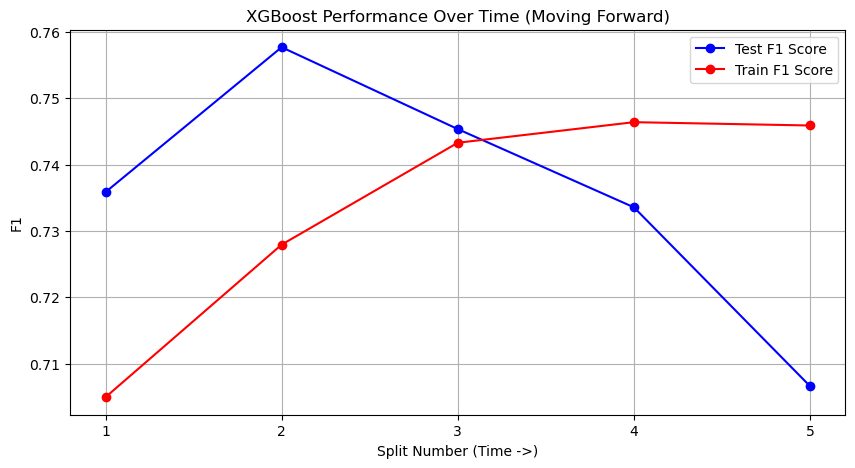

In [25]:
# Visualize the trend (code adapted from Gemini 3)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 6), xgb_cv['test_f1'], 
         marker='o', linestyle='-', color='b', label='Test F1 Score')

plt.plot(range(1, 6), xgb_cv['train_f1'], 
         marker='o', linestyle='-', color='r', label='Train F1 Score')

plt.title('XGBoost Performance Over Time (Moving Forward)')
plt.xlabel('Split Number (Time ->)')
plt.ylabel('F1')
plt.grid(True)
plt.xticks([1, 2, 3, 4, 5])
plt.legend()
plt.show()

The plot above shows how the **F1** score changes over training splits. 

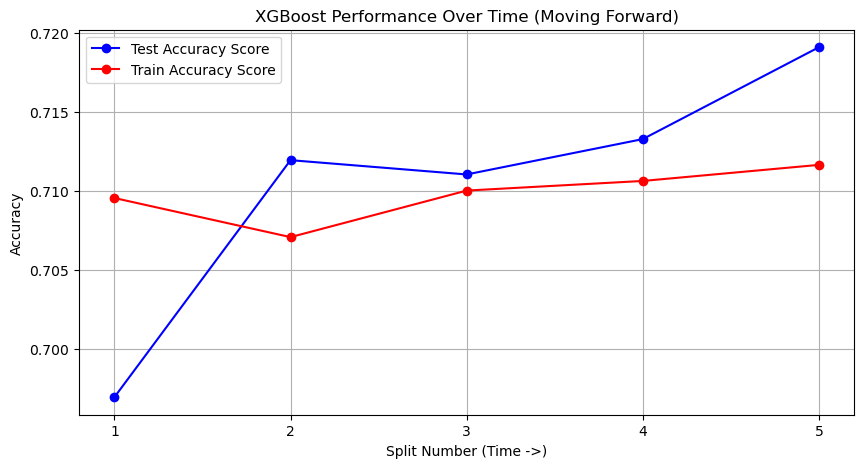

In [26]:
# Visualize the trend (code adapted from Gemini 3)

plt.figure(figsize=(10, 5))

plt.plot(range(1, 6), xgb_cv['test_accuracy'], 
         marker='o', linestyle='-', color='b', label='Test Accuracy Score')

plt.plot(range(1, 6), xgb_cv['train_accuracy'], 
         marker='o', linestyle='-', color='r', label='Train Accuracy Score')

plt.title('XGBoost Performance Over Time (Moving Forward)')
plt.xlabel('Split Number (Time ->)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks([1, 2, 3, 4, 5])
plt.legend()
plt.show()

The plot above shows how the **accuracy** score changes over training splits. 

**Increasing trend -> model is learning. But Test score is still higher than Train score -> still underfitting.**

In [27]:
# fit the models
pipe_lr.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('standardscaler', ...), ('passthrough', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [28]:
pipe_xgb.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('xgbclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('standardscaler', ...), ('passthrough', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Feature Importance

From the plot below, we can see that the model prediction is dominated by the two main features I created: `movie_historical_avg` and `user_historical_avg`. 

Why my XGBoost have a similar performance score as the Logistic Regression?

- only two main features --> strong linear relationship (ie. if the movie's average rating is high, then the rating is likely to be high)
- XGBoost shines when there are complex, non-linear relationships between variables, but I am not using the model to its full potential.

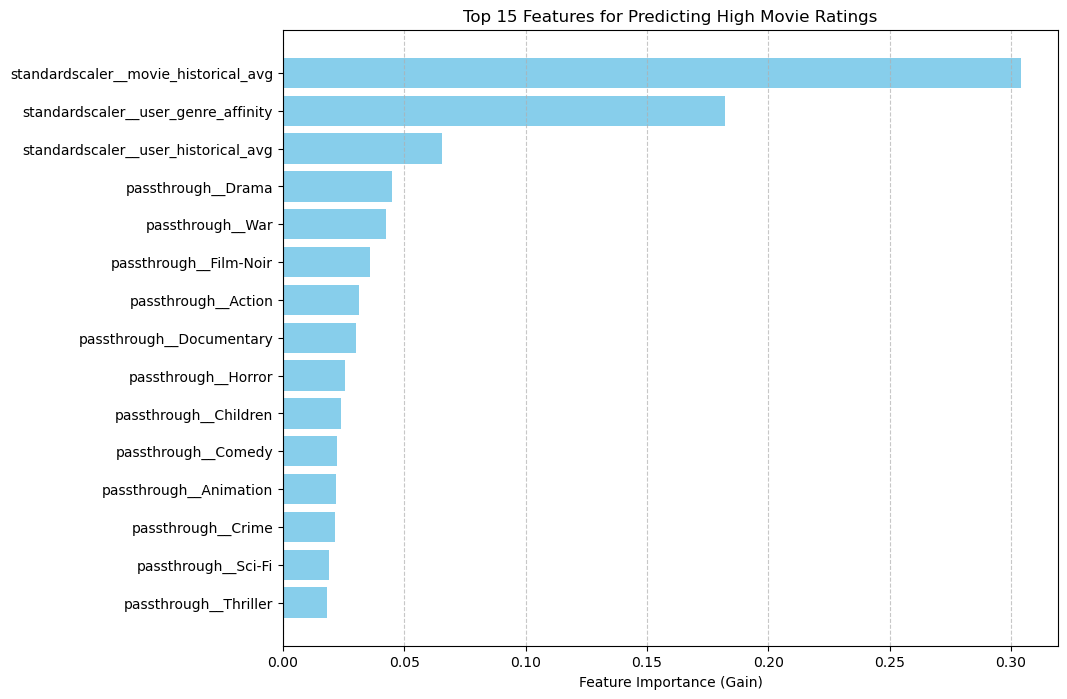

In [29]:
feature_names = pipe_xgb.named_steps['columntransformer'].get_feature_names_out()
importances = pipe_xgb.named_steps['xgbclassifier'].feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'][:15][::-1], importance_df['Importance'][:15][::-1], color='skyblue')
plt.xlabel('Feature Importance (Gain)')
plt.title('Top 15 Features for Predicting High Movie Ratings')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Results

In [30]:
print(classification_report(y_test, pipe_lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.74      0.69      0.72   5270409
           1       0.68      0.73      0.71   4729723

    accuracy                           0.71  10000132
   macro avg       0.71      0.71      0.71  10000132
weighted avg       0.72      0.71      0.71  10000132



In [31]:
print(classification_report(y_test, pipe_xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.75      0.70      0.72   5270409
           1       0.69      0.74      0.71   4729723

    accuracy                           0.72  10000132
   macro avg       0.72      0.72      0.72  10000132
weighted avg       0.72      0.72      0.72  10000132



From the above results, it reveals an imbalance in how the model handles the two classes. 

Specifically, a higher Recall for Class 1 and a higher Precision for Class 0 -> the model is leaning heavily toward predicting Class 1 ('High' ratings). By predicting Class 1 more frequently, the model successfully identifies most of the true high ratings (low FN for Class 1), but at the cost of incorrectly classifying many low ratings as high (high FP for Class 1).

# Discussion and Conclusion

My final model has an accuracy of 71% and a F1 score of 71%. As a baseline model, I chose Logistic Regression because it is simple and fast, providing a "floor" for performance with a test accuracy of 71%. For my main model, I chose eXtreme Gradient Boosting (XGBoost) due to its well-known ability to handle non-linear relationships and its robustness in classification tasks.

## Feature Engineering
I engineered two features: `user_historical_avg` and `movie_historical_avg`. 

The feature `user_historical_avg` measures the average rating a user gave based on data strictly prior to the current timestamp. I believe this is an important feature because users often have different rating scales (e.g., some average a 5/10 while others average a 7/10 for neutral sentiment). Accounting for this "user bias" acts as a form of standardization for the predicted response.

The feature `movie_historical_avg` represents the average score that the general public rated a movie in the past. While this provides a strong baseline for movie quality, its predictive power varies as individual tastes differ from the global average.

## Data Leakage Considerations
To prevent breaking the Golden Rule of machine learning, I used `shift(1)` and `expanding().mean()` to ensure that features only utilized information available at the time of the event. Furthermore, I implemented a `TimeSeriesSplit` strategy for cross-validation to simulate a production environment where the model is trained on cumulative, chronological data.

Dealing with a dataset of 20 million rows (and 10 million in the training set) presented significant memory challenges. To prevent system crashes encountered during automated hyperparameter tuning, I used a manual tuning strategy with `subsample=0.6` and `colsample_bytree=0.6`. This limited memory overhead while maintaining high performance.

## Future steps
- **Incorporate Richer Datasets**: Integrating `genome_scores`, `genome_tags`, `link`, and `tag` datasets would introduce complex, non-linear relationships that a baseline model cannot capture, likely improving prediction accuracy.
- **Engineer Genre Affinity**: I plan to create a "Genre Affinity" feature to measure how frequently a user has rated specific genres as "High" in the past, capturing deeper personalized preferences.
- **Dynamic Weighting**: My analysis revealed a slight performance dip in the final time split (falling from 71.4% to 70.8%), which suggests Concept Drift as user tastes evolve. Future iterations should weight recent data more heavily than older data to remain responsive to changing trends.